

> TFG (No es la version final)




1.   Importación de datos
2.   Preprocesamiento de los datos
3.   Modelo de clasificacion (transfer learning y modelo simple)
4.   Modelo de segmentacion con los resultados del modelo anterior
5.   Representacion de los resultados




# Librerias

In [1]:
import zipfile
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Importación de los datos


In [2]:
def extract_zip(zip_path, dest_dir):
    """
    Extrae el contenido de un archivo zip a un directorio de destino.

    Args:
        zip_path (str): La ruta al archivo zip.
        dest_dir (str): El directorio donde se extraerán los archivos.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

# Define las rutas del archivo zip y el directorio de destino
zip_file_path = '/content/archive.zip'
destination_directory = '/content'

# Llama a la función para extraer el archivo
if os.path.exists(zip_file_path):
    extract_zip(zip_file_path, destination_directory)
    print(f"Archivo '{zip_file_path}' extraído a '{destination_directory}'")
else:
    print(f"El archivo '{zip_file_path}' no fue encontrado.")

Archivo '/content/archive.zip' extraído a '/content'


In [3]:
def importar(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path)
                image_list.append(img)
            except Exception as e:
                print(f"No se pudo abrir la imagen {filename}: {e}")
    return image_list

In [4]:
imagenes_ct_sanas = importar('/content/Dataset/Brain Tumor CT scan Images/Healthy')
imagenes_ct_tumor = importar('/content/Dataset/Brain Tumor CT scan Images/Tumor')
imagenes_mri_sanas = importar('/content/Dataset/Brain Tumor MRI images/Healthy')
imagenes_mri_tumor = importar('/content/Dataset/Brain Tumor MRI images/Tumor')

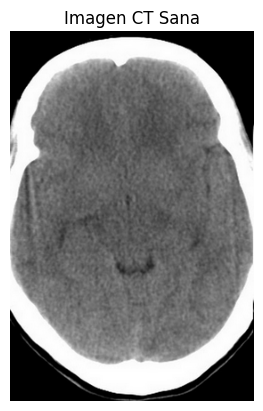

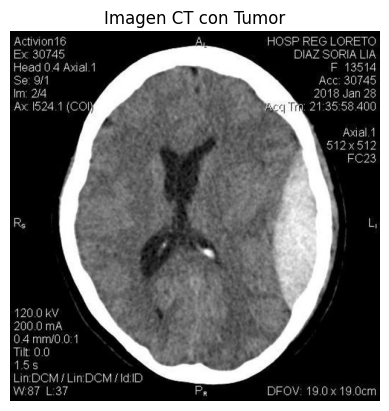

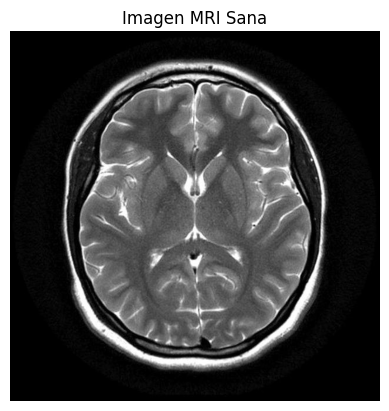

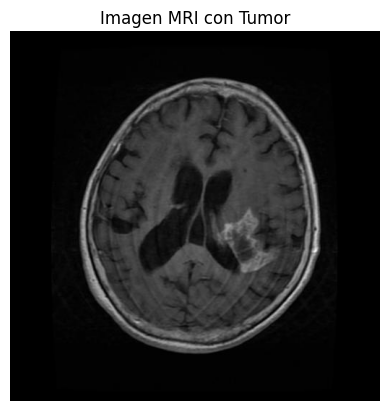

In [5]:
def display_image(image_list, title):
    if image_list:
        random_index = np.random.randint(0, len(image_list))
        plt.imshow(image_list[random_index], cmap='grey')
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print(f"La lista '{title}' está vacía.")

display_image(imagenes_ct_sanas, "Imagen CT Sana")
display_image(imagenes_ct_tumor, "Imagen CT con Tumor")
display_image(imagenes_mri_sanas, "Imagen MRI Sana")
display_image(imagenes_mri_tumor, "Imagen MRI con Tumor")

# 2. Preprocesamiento de los datos

In [6]:
def preprocess_images(image_list, target_size=(256, 256)):
    processed_images = []
    for img in image_list:
        # Convierto a array NumPy y asegurar que sea RGB
        img_array = np.array(img.convert('RGB')) if img.mode != 'RGB' else np.array(img)
        # Redimensiono todas las imágenes al mismo tamaño objetivo
        resized_img = cv2.resize(img_array, target_size)
        # Normalizo (escalar los valores de píxel a un rango de 0 a 1)
        normalized_img = resized_img.astype('float32') / 255.0
        processed_images.append(normalized_img)
    return processed_images

imagenes_ct_sanas_processed = preprocess_images(imagenes_ct_sanas)
imagenes_ct_tumor_processed = preprocess_images(imagenes_ct_tumor)
imagenes_mri_sanas_processed = preprocess_images(imagenes_mri_sanas)
imagenes_mri_tumor_processed = preprocess_images(imagenes_mri_tumor)

print(f"Se preprocesaron {len(imagenes_ct_sanas_processed)} imágenes CT sanas.")
print(f"Se preprocesaron {len(imagenes_ct_tumor_processed)} imágenes CT con tumor.")
print(f"Se preprocesaron {len(imagenes_mri_sanas_processed)} imágenes MRI sanas.")
print(f"Se preprocesaron {len(imagenes_mri_tumor_processed)} imágenes MRI con tumor.")

Se preprocesaron 2300 imágenes CT sanas.
Se preprocesaron 2318 imágenes CT con tumor.
Se preprocesaron 2000 imágenes MRI sanas.
Se preprocesaron 3000 imágenes MRI con tumor.


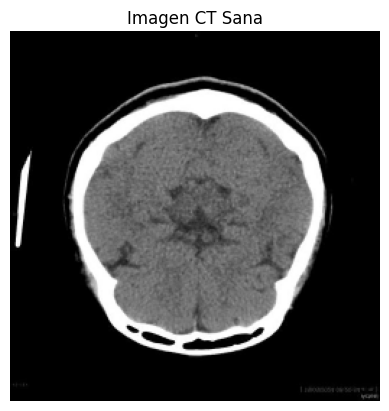

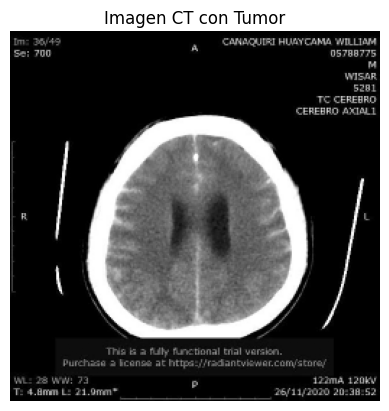

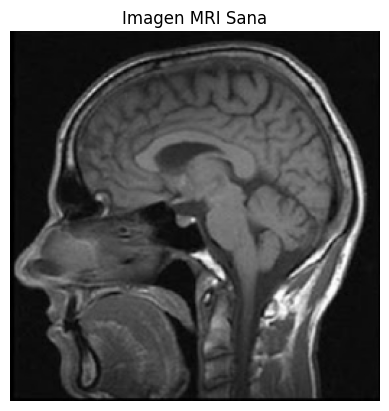

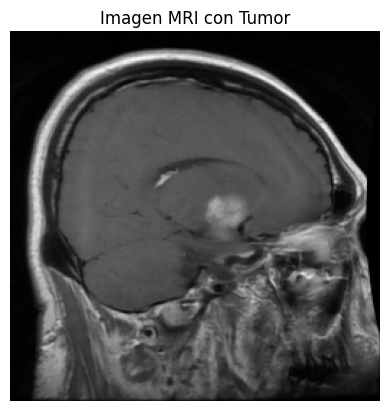

In [7]:
display_image(imagenes_ct_sanas_processed, "Imagen CT Sana")
display_image(imagenes_ct_tumor_processed, "Imagen CT con Tumor")
display_image(imagenes_mri_sanas_processed, "Imagen MRI Sana")
display_image(imagenes_mri_tumor_processed, "Imagen MRI con Tumor")

# 3. Modelo de clasificación conjunto ct

Primer modelo, voy a ir cambiando el modelo hasta llegar a un modelo con un rendimiento mejorado respecto al resto.

## Primer modelo

In [8]:
imagenes_ct = imagenes_ct_sanas_processed + imagenes_ct_tumor_processed
# 0 para sanas, 1 para tumor
labels_ct = [0] * len(imagenes_ct_sanas_processed) + [1] * len(imagenes_ct_tumor_processed)
imagenes_ct = np.array(imagenes_ct)
labels_ct = np.array(labels_ct)
X_train_ct, X_test_ct, y_train_ct, y_test_ct = train_test_split(
    imagenes_ct, labels_ct,
    test_size=0.2, random_state=42, stratify=labels_ct)
print(f"Tamaño del conjunto de entrenamiento: {len(X_train_ct)}")
print(f"Tamaño del conjunto de prueba: {len(X_test_ct)}")

Tamaño del conjunto de entrenamiento: 3694
Tamaño del conjunto de prueba: 924


In [77]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │       246,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,417 (966.47 KB)

 Trainable params: 247,417 (966.47 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Entreno el modelo
history = model.fit(X_train_ct, y_train_ct, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.7352 - loss: 0.4950 - val_accuracy: 0.8945 - val_loss: 0.2542
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9367 - loss: 0.1564 - val_accuracy: 0.9378 - val_loss: 0.1625
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9709 - loss: 0.0902 - val_accuracy: 0.9350 - val_loss: 0.1738
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9731 - loss: 0.0746 - val_accuracy: 0.9391 - val_loss: 0.1743
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9871 - loss: 0.0395 - val_accuracy: 0.9418 - val_loss: 0.1979
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9913 - loss: 0.0276 - val_accuracy: 0.9391 - val_loss: 0.2140
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9961 - loss: 0.0203 - val_accuracy: 0.9445 - val_loss: 0.1963
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9976 - loss: 0.0136 - val_accuracy: 0.9418 - 

In [79]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9516 - loss: 0.3656
Pérdida en el conjunto de prueba: 0.3887
Precisión en el conjunto de prueba: 0.9448


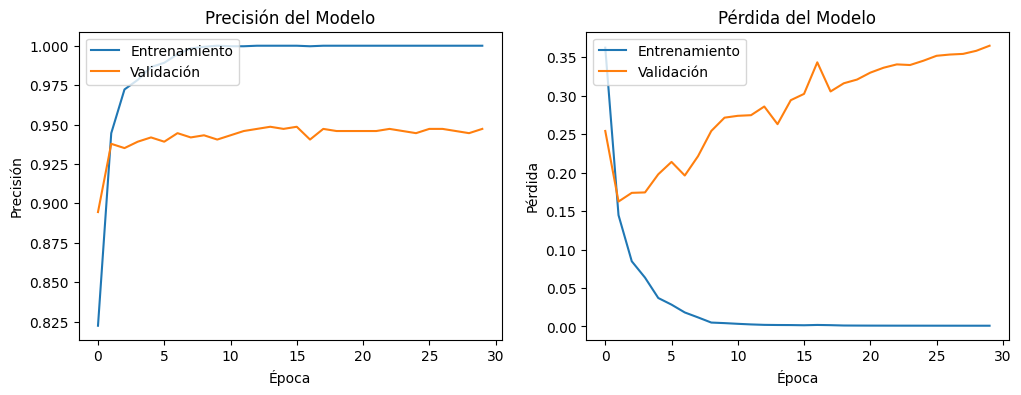

In [80]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


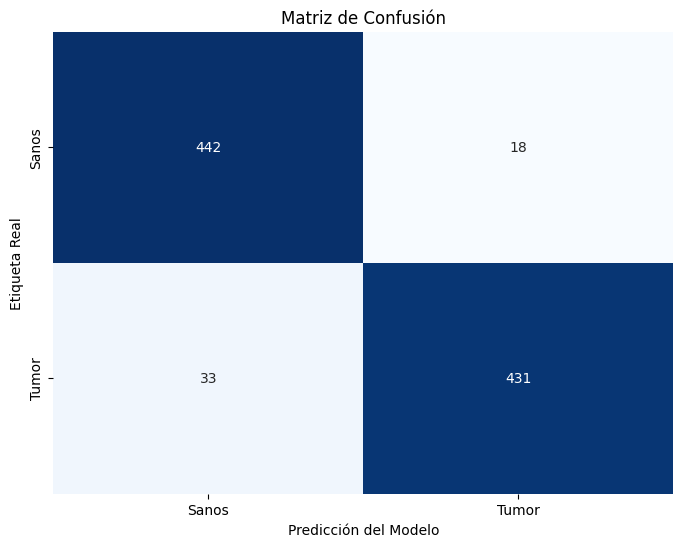

In [81]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

## Segundo modelo

In [52]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 60, 60, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 30, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 30, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4)              │        28,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,361 (122.50 KB)

 Trainable params: 31,361 (122.50 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Entreno el modelo
history = model.fit(X_train_ct, y_train_ct, epochs=70, batch_size=64, validation_split=0.2)

Epoch 1/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.7306 - loss: 0.5203 - val_accuracy: 0.7145 - val_loss: 0.5543
Epoch 2/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8620 - loss: 0.3108 - val_accuracy: 0.7876 - val_loss: 0.4398
Epoch 3/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8910 - loss: 0.2541 - val_accuracy: 0.8566 - val_loss: 0.3478
Epoch 4/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9046 - loss: 0.2154 - val_accuracy: 0.8742 - val_loss: 0.2997
Epoch 5/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9132 - loss: 0.1888 - val_accuracy: 0.9107 - val_loss: 0.2853
Epoch 6/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9327 - loss: 0.1664 - val_accuracy: 0.9202 - val_loss: 0.2368
Epoch 7/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9373 - loss: 0.1441 - val_accuracy: 0.9269 - val_loss: 0.2177
Epoch 8/70
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9485 - loss: 0.1409 - val_accuracy: 0.9323 -

In [54]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9512 - loss: 0.1098
Pérdida en el conjunto de prueba: 0.1282
Precisión en el conjunto de prueba: 0.9470


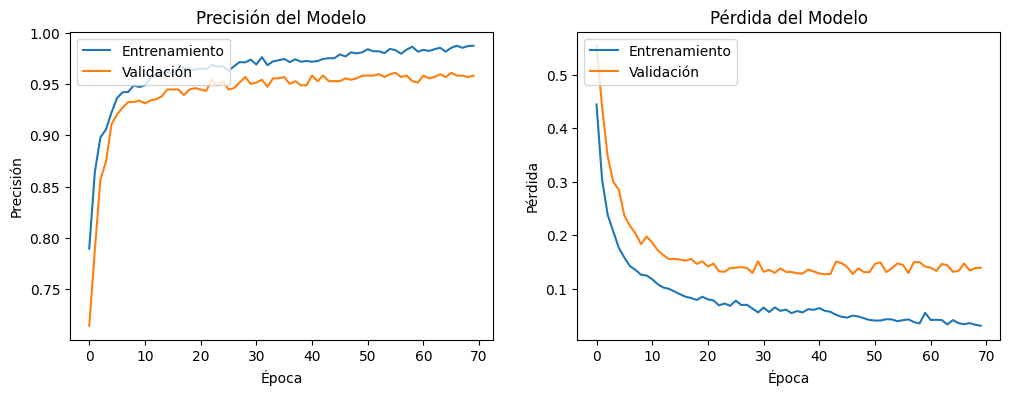

In [55]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


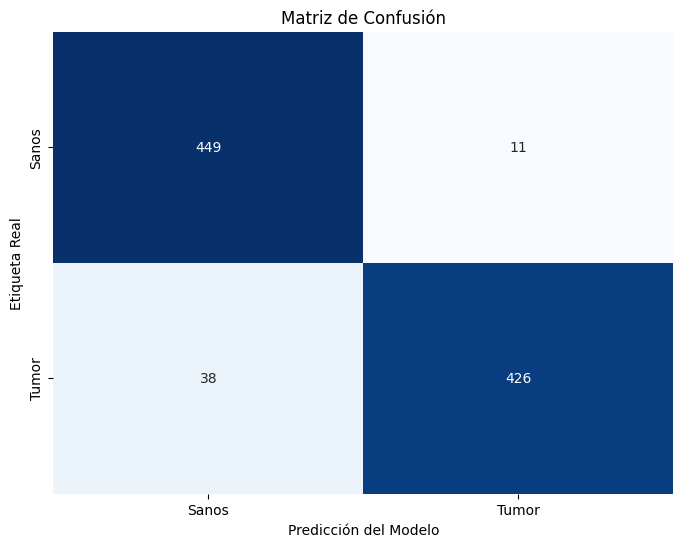

In [57]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

## Tercer modelo

In [87]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 12, 12, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 4, 4, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,857 (757.25 KB)

 Trainable params: 193,857 (757.25 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Entreno el modelo
history = model.fit(X_train_ct, y_train_ct, epochs=85, batch_size=32, validation_split=0.2)

Epoch 1/85
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.6126 - loss: 0.6505 - val_accuracy: 0.8633 - val_loss: 0.4011
Epoch 2/85
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8491 - loss: 0.3350 - val_accuracy: 0.8945 - val_loss: 0.3201
Epoch 3/85
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8996 - loss: 0.2680 - val_accuracy: 0.9175 - val_loss: 0.2654
Epoch 4/85
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9024 - loss: 0.2342 - val_accuracy: 0.9296 - val_loss: 0.1959
Epoch 5/85
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9154 - loss: 0.1960 - val_accuracy: 0.9337 - val_loss: 0.1680
Epoch 6/85
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9312 - loss: 0.1838 - val_accuracy: 0.9337 - val_loss: 0.1660
Epoch 7/85
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9369 - loss: 0.1446 - val_accuracy: 0.9405 - val_loss: 0.1541
Epoch 8/85
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9377 - loss: 0.1490 - val_accuracy: 0.9432 -

In [89]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9720 - loss: 0.0805
Pérdida en el conjunto de prueba: 0.1054
Precisión en el conjunto de prueba: 0.9643


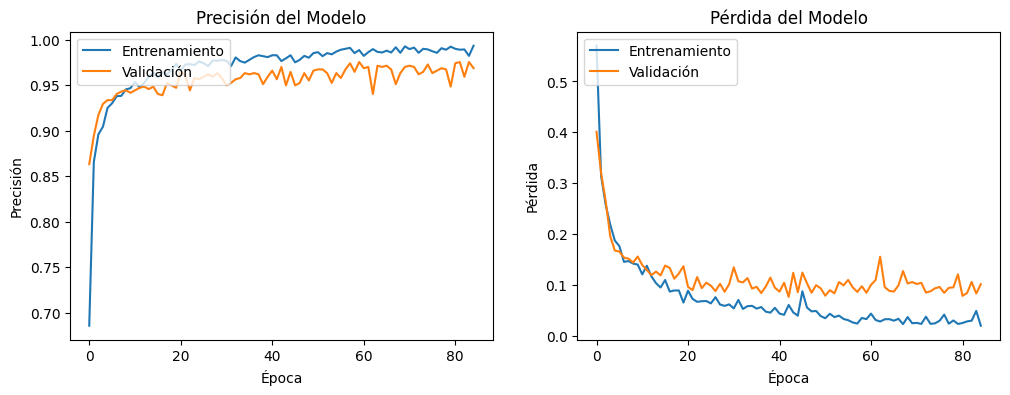

In [90]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


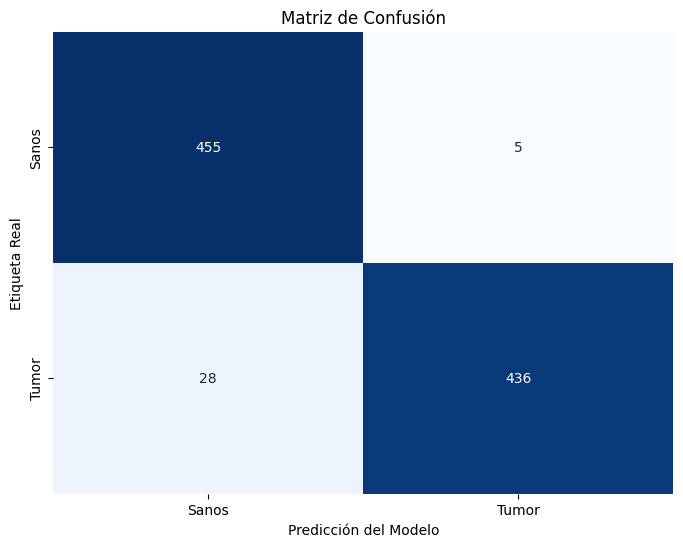

In [91]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

## Cuarto modelo

In [11]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,857 (757.25 KB)

 Trainable params: 193,857 (757.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Entreno el modelo
history = model.fit(X_train_ct, y_train_ct, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.5064 - loss: 0.7750 - val_accuracy: 0.5291 - val_loss: 0.6916
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5582 - loss: 0.6819 - val_accuracy: 0.6143 - val_loss: 0.6855
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6091 - loss: 0.6532 - val_accuracy: 0.6509 - val_loss: 0.6688
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6958 - loss: 0.5949 - val_accuracy: 0.7158 - val_loss: 0.6507
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7229 - loss: 0.5722 - val_accuracy: 0.7253 - val_loss: 0.6414
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7601 - loss: 0.5291 - val_accuracy: 0.7781 - val_loss: 0.6269
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7615 - loss: 0.5315 - val_accuracy: 0.8011 - val_loss: 0.5873
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8072 - loss: 0.4570 - val_accuracy: 

In [13]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9799 - loss: 0.0584
Pérdida en el conjunto de prueba: 0.0863
Precisión en el conjunto de prueba: 0.9729


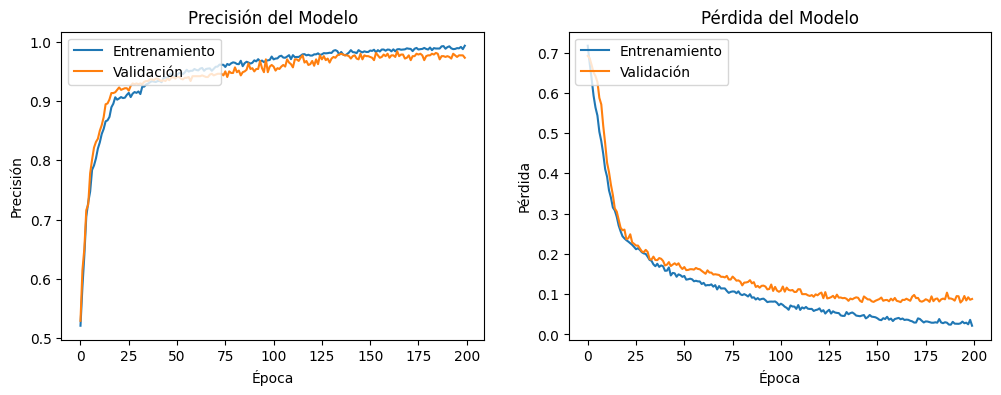

In [14]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


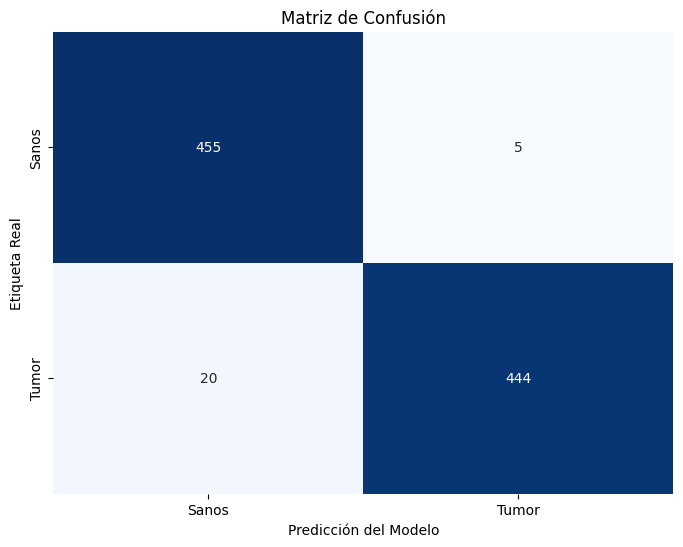

In [15]:
y_pred_prob = model.predict(X_test_ct)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_ct, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# 4. Modelo de clasificación conjunto mri

Primer modelo, voy a ir cambiando el modelo hasta llegar a un modelo con un rendimiento mejorado respecto al resto.

## Primer modelo

In [8]:
imagenes_mri = imagenes_mri_sanas_processed + imagenes_mri_tumor_processed
# 0 para sanas, 1 para tumor
labels_mri = [0] * len(imagenes_mri_sanas_processed) + [1] * len(imagenes_mri_tumor_processed)
imagenes_mri = np.array(imagenes_mri)
labels_mri = np.array(labels_mri)
X_train_mri, X_test_mri, y_train_mri, y_test_mri = train_test_split(
    imagenes_mri, labels_mri,
    test_size=0.2, random_state=42, stratify=labels_mri)
print(f"Tamaño del conjunto de entrenamiento: {len(X_train_mri)}")
print(f"Tamaño del conjunto de prueba: {len(X_test_mri)}")

Tamaño del conjunto de entrenamiento: 4000
Tamaño del conjunto de prueba: 1000


In [17]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │       492,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,441 (1.88 MB)

 Trainable params: 493,441 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Entreno el modelo
history = model.fit(X_train_mri, y_train_mri, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5530 - loss: 0.7985 - val_accuracy: 0.5900 - val_loss: 0.6906
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6098 - loss: 0.6892 - val_accuracy: 0.5900 - val_loss: 0.6879
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5995 - loss: 0.6866 - val_accuracy: 0.5900 - val_loss: 0.6855
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6137 - loss: 0.6825 - val_accuracy: 0.5900 - val_loss: 0.6835
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5949 - loss: 0.6823 - val_accuracy: 0.5900 - val_loss: 0.6817
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6077 - loss: 0.6784 - val_accuracy: 0.5900 - val_loss: 0.6804
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6080 - loss: 0.6766 - val_accuracy: 0.5900 - val_loss: 0.6794
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6040 - loss: 0.6761 - val_accuracy: 0.5900 - v

In [19]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5946 - loss: 0.6752
Pérdida en el conjunto de prueba: 0.6730
Precisión en el conjunto de prueba: 0.6000


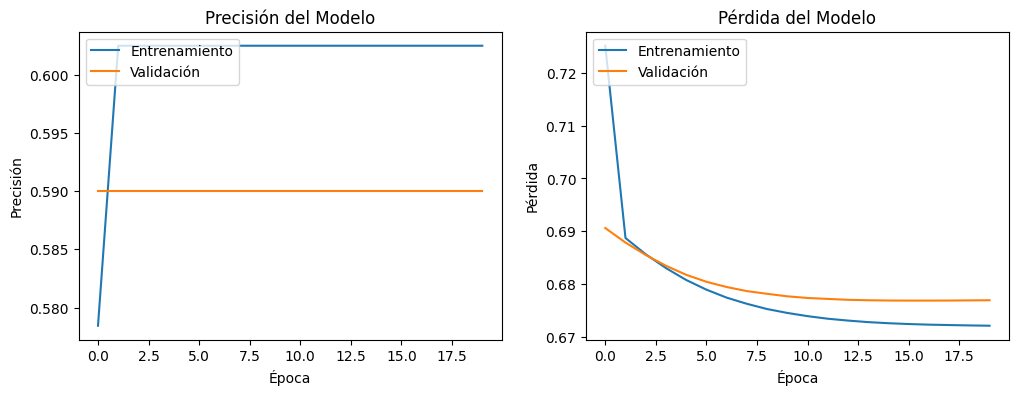

In [20]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


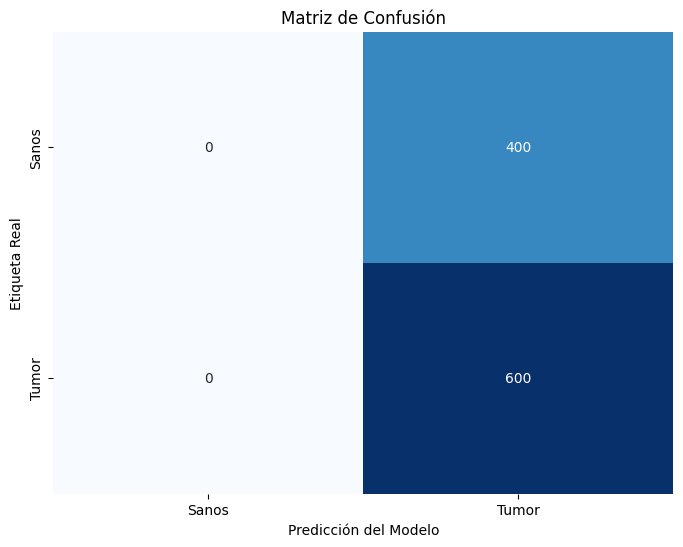

In [21]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

## Segundo modelo

In [10]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        12,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,209 (90.66 KB)

 Trainable params: 23,209 (90.66 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Entreno el modelo
history = model.fit(X_train_mri, y_train_mri, epochs=60, batch_size=64, validation_split=0.2)

Epoch 1/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.6039 - loss: 0.6905 - val_accuracy: 0.5900 - val_loss: 0.6685
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5958 - loss: 0.6157 - val_accuracy: 0.5900 - val_loss: 0.5554
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6912 - loss: 0.5344 - val_accuracy: 0.7788 - val_loss: 0.5176
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8020 - loss: 0.4877 - val_accuracy: 0.7788 - val_loss: 0.5071
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8241 - loss: 0.4631 - val_accuracy: 0.7412 - val_loss: 0.5125
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8527 - loss: 0.4310 - val_accuracy: 0.8037 - val_loss: 0.4807
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8707 - loss: 0.3890 - val_accuracy: 0.7700 - val_loss: 0.4577
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8739 - loss: 0.3868 - val_accuracy: 0.8288 -

In [12]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9537 - loss: 0.1935
Pérdida en el conjunto de prueba: 0.1744
Precisión en el conjunto de prueba: 0.9610


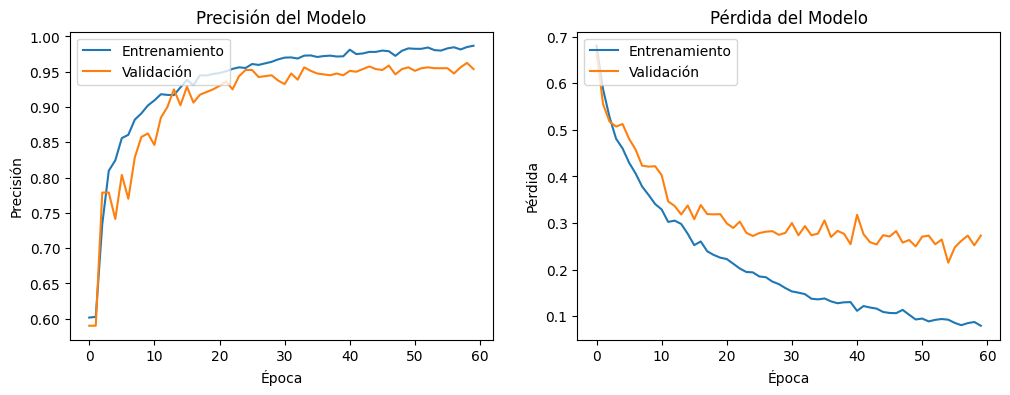

In [13]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


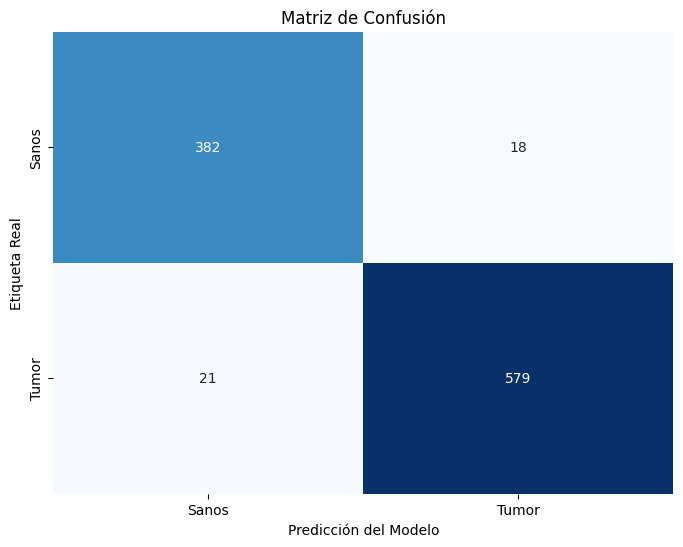

In [15]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

## Tercer modelo

In [9]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    # Conv2D(128, (3, 3), activation='relu', padding='same'),
    # MaxPooling2D((2, 2)),
    # Dropout(0.65),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,681 (748.75 KB)

 Trainable params: 191,681 (748.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Entreno el modelo
history = model.fit(X_train_mri, y_train_mri, epochs=130, batch_size=32, validation_split=0.2)

Epoch 1/130
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.6170 - loss: 0.6711 - val_accuracy: 0.7575 - val_loss: 0.4970
Epoch 2/130
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7622 - loss: 0.5069 - val_accuracy: 0.7675 - val_loss: 0.4871
Epoch 3/130
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8303 - loss: 0.3708 - val_accuracy: 0.7975 - val_loss: 0.4647
Epoch 4/130
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8784 - loss: 0.2970 - val_accuracy: 0.8213 - val_loss: 0.4481
Epoch 5/130
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9057 - loss: 0.2335 - val_accuracy: 0.8487 - val_loss: 0.3977
Epoch 6/130
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9220 - loss: 0.2107 - val_accuracy: 0.9162 - val_loss: 0.2221
Epoch 7/130
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9302 - loss: 0.1855 - val_accuracy: 0.9212 - val_loss: 0.2021
Epoch 8/130
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9528 - loss: 0.1469 -

In [11]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9876 - loss: 0.0764
Pérdida en el conjunto de prueba: 0.0720
Precisión en el conjunto de prueba: 0.9890


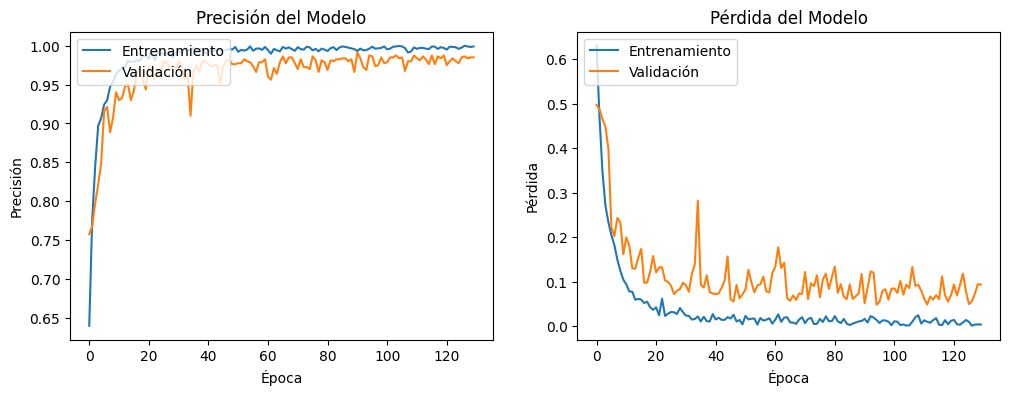

In [12]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


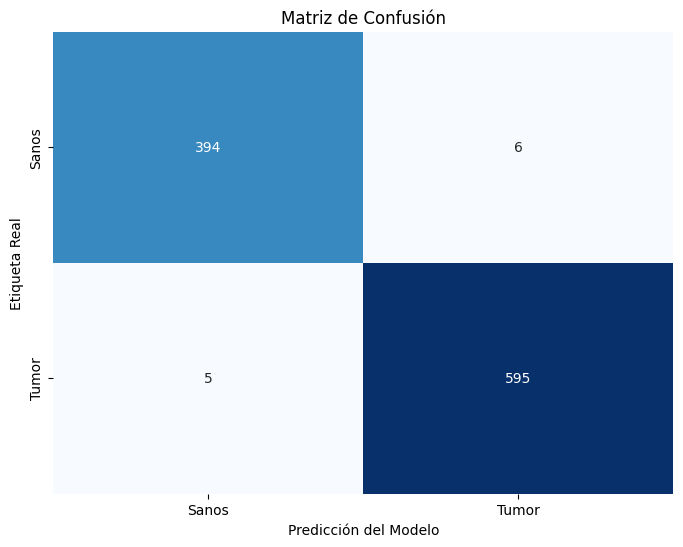

In [13]:
y_pred_prob = model.predict(X_test_mri)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
cm = confusion_matrix(y_test_mri, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sanos', 'Tumor'], # Puedes cambiar estos nombres por 'Perro', 'Gato', etc.
            yticklabels=['Sanos', 'Tumor'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()